# UR Desa Sentinel 10m TC

Kode modelling klasifikasi densenet dan resnet urban rural pada data sentinel 2 10m dengan neighbor True crop, input tingkat desa.

### Import Fast Ai

In [3]:
import fastai
from fastai.vision.all import *
import pandas as pd

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

Buka data variabel

In [6]:
sls = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/3200_sls.csv")

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
sls.head()

,id,kdprov,kdkab,kdkec,kddesa,iddesa,idslsnon,nmslsnon,ketua_sls,jenis,...,j_bstt,j_bsbtt,j_bstt_k,j_bskeko,j_segmen,dom,ldom,j_m_all,j_m_30,klas_ur
0,263884,32,1,10,1,3201010001,100,RT 001 RW 001 DUSUN 1,MUHAMAD RAFLI HIDAYAT,1,...,39,1,2,4,1,1,1,51,51,2
1,263885,32,1,10,1,3201010001,200,RT 002 RW 001 DUSUN 1,NURMAN,1,...,60,2,0,7,1,1,1,62,61,2
2,263886,32,1,10,1,3201010001,300,RT 003 RW 001 DUSUN 1,SAENUDIN,1,...,50,2,0,6,1,1,1,58,57,2
3,263887,32,1,10,1,3201010001,400,RT 004 RW 001 DUSUN 1,AEP,1,...,27,1,0,1,1,1,1,31,31,2
4,263888,32,1,10,1,3201010001,500,RT 005 RW 001 DUSUN 1,JEJEN JAELANI,1,...,49,7,3,8,3,1,1,63,57,2


In [6]:
sls.iddesa.unique().shape

(5957,)

Proses pembentukan dan distribusi citra ke folder urban rural untuk citra bersesuaian sesuai dengan format fast ai

In [9]:
yourpath = "C:/Users/jwst2/Python/tesis/jpg/jabartruecrop/"
from tqdm import tqdm
for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
    for name in files:
        try :
            if(sls.klas_ur[sls.iddesa == int(name.replace(".jpg","")[:10])].iloc[0] == 1):
                shutil.copy(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/jabar10m_ur_truecrop/urban/"+name)
            elif(sls.klas_ur[sls.iddesa == int(name.replace(".jpg","")[:10])].iloc[0] == 2):
                shutil.copy(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/jabar10m_ur_truecrop/rural/"+name)
        except Exception:
            print(name)
            pass 

0it [00:00, ?it/s]

3207000000.jpg
3208000000.jpg
3208010000.jpg
3211080000.jpg
3211111000.jpg
3217000000.jpg


1it [00:22, 22.61s/it]


### Run Dataset

Preprocessing penyiapan data citra untuk diload perbatch ke fast ai.

In [5]:
path = Path.cwd() / ("C:/Users/jwst2/Python/tesis/jpg/UR/01 Sentinel 10M Desa Truecrop")

In [6]:
Path.BASE_PATH = path
path.ls()

(#2) [Path('rural'),Path('urban')]

In [7]:
fname = (path/"rural").ls()[0]
fname

Path('rural/3201010001.jpg')

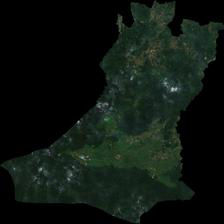

In [8]:
img = Image.open(fname)
img

Pembentukan data block

In [9]:
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(valid_pct=0.1, seed=42),  # default random split 80% training, 20% validation
                 get_y=parent_label, # extracts the label category from the image's folder name 
                 batch_tfms=aug_transforms(mult=2)) # data augmentation (mult multiplies the default transformation values)

Load dan print conto batch

In [10]:
dls = blocks.dataloaders(path,bs=4)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


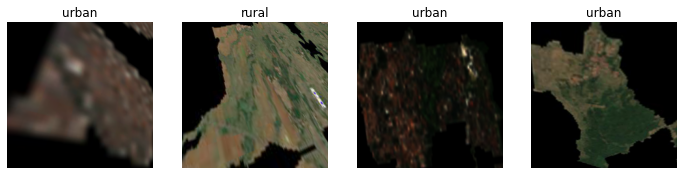

In [11]:
dls.show_batch(nrows=1)

Pemodelan densenet dengan metrik bersesuaian

In [ ]:
avg = 'macro'
roca = RocAucBinary(average=avg)
f1s = F1Score(average=avg)
bc = BalancedAccuracy()
metrics=[accuracy,bc, Precision(average=avg), Recall(average=avg), f1s, roca]
learn = cnn_learner(dls, densenet121, metrics=metrics) 
learn.summary()

Mencari batas maksimum untuk learning rate

SuggestedLRs(valley=0.0008317637839354575)

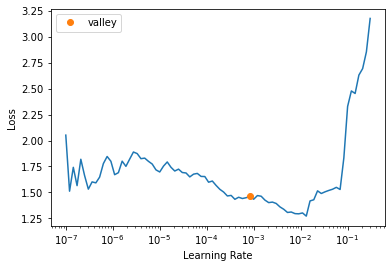

In [15]:
learn.lr_find()

Smith fit one cycle terhadap densenet

In [44]:
learn.fit_one_cycle(15,1e-3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.825821,0.562259,0.761345,0.739852,0.714715,0.739852,0.723151,0.820536,04:04
1,0.574132,0.671220,0.732773,0.734387,0.697616,0.734387,0.703136,0.792475,04:17
2,0.576982,0.460525,0.783193,0.713554,0.732621,0.713554,0.721524,0.826252,04:23
3,0.553036,0.397740,0.810084,0.784641,0.766101,0.784641,0.773910,0.883963,04:12
4,0.519959,0.402457,0.796639,0.748195,0.749098,0.748195,0.748643,0.865493,04:12
5,0.521457,0.432794,0.784874,0.665984,0.757304,0.665984,0.685029,0.852640,04:17
6,0.507101,0.398673,0.813445,0.725605,0.785714,0.725605,0.745158,0.875446,04:21
7,0.480051,0.377846,0.826891,0.751220,0.799789,0.751220,0.768929,0.888703,04:11
8,0.476184,0.375113,0.830252,0.742730,0.815444,0.742730,0.765877,0.890348,04:11
9,0.433740,0.367318,0.821849,0.715213,0.822280,0.715213,0.742007,0.902295,04:11


In [45]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.437038,0.370291,0.836975,0.743804,0.834945,0.743804,0.770631,0.897360,04:06
1,0.509208,0.400477,0.793277,0.659202,0.799703,0.659202,0.680008,0.886640,04:14
2,0.414965,0.393670,0.808403,0.689598,0.810710,0.689598,0.714693,0.886068,04:16
3,0.466141,0.362038,0.835294,0.757075,0.815757,0.757075,0.777626,0.907620,04:14
4,0.428699,0.359787,0.840336,0.755172,0.831612,0.755172,0.779785,0.914631,04:14


In [216]:
dls.train.items[175000]

Path('urban/32160100130020.jpg')

Export model

In [46]:
learn.export('C:/Users/jwst2/Python/tesis/models/18042022 D006.pkl')

### Resnet

Pembentukan model semisal untuk resnet

In [16]:
learn_rs = cnn_learner(dls, resnet50, metrics=metrics) 

SuggestedLRs(valley=0.0005754399462603033)

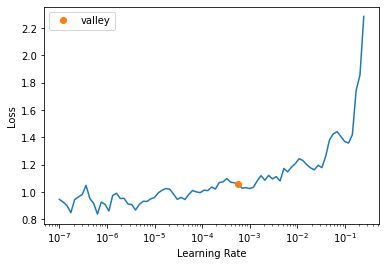

In [18]:
learn_rs.lr_find()

In [50]:
learn_rs.fit_one_cycle(15,10-3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.839068,0.536386,0.766387,0.712676,0.711913,0.712676,0.712291,0.812019,02:14
1,0.675989,0.509505,0.788235,0.709846,0.741149,0.709846,0.721657,0.807893,02:17
2,0.545235,0.463389,0.756303,0.689403,0.697583,0.689403,0.693108,0.812646,02:17
3,0.580465,0.444898,0.774790,0.716725,0.721638,0.716725,0.719063,0.832093,02:18
4,0.547034,0.405424,0.808403,0.760002,0.763872,0.760002,0.761880,0.864949,02:17
5,0.566570,0.435662,0.796639,0.728337,0.751034,0.728337,0.737724,0.843440,02:19
6,0.526024,0.433312,0.727731,0.517857,0.862479,0.517857,0.454758,0.861227,02:23
7,0.517135,0.443291,0.811765,0.733460,0.777047,0.733460,0.749300,0.878248,02:23
8,0.481375,0.356629,0.838655,0.793716,0.802730,0.793716,0.797974,0.907452,02:18
9,0.486261,0.364540,0.836975,0.788934,0.801413,0.788934,0.794700,0.901848,02:18


Ekpor model resnet

In [51]:
learn_rs.export('C:/Users/jwst2/Python/tesis/models/18042022 R006.pkl')